# Study Case A
This notebook will showcase an overview of the Devices and Samples models, displaying statistical summaries and distribuitions for each model. Afterwards, we will add new features in attempt to answer the proposed questions.

**Note:** Dataset snapshot used was generated on 2018-06-17. Only **records after 2017-10-15** are being loaded.

## Questions and problem definition
**[WIP]** Define the problem and its questions

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)


# helper functions
def load_df(path, columns=None, nthreads=4, strings_to_categorical=True):
    try:
        table = pq.read_table(path, columns=columns, nthreads=nthreads)
        return table.to_pandas(strings_to_categorical=strings_to_categorical)
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    return df
        
def prepare_devices(path):
    cols = ['id', 'model', 'brand', 'manufacturer', 'product', 'os_version', 'kernel_version', 'is_root']
    return load_df(path, cols)
        
def prepare_samples(path):
    cols = ['device_id', 'timestamp', 'battery_level', 'network_status', 'voltage',
            'temperature', 'screen_on', 'bluetooth_enabled', 'location_enabled', 
            'power_saver_enabled', 'nfc_enabled', 'unknown_sources', 'developer_mode']
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)
    df = df.reset_index(drop=True)
    # df = downcast_ints(df)
    return df

## Acquire data
After importing the necessary libraries, we load the files into dataframes. The *samples* data was sorted beforehand by *device_id* and *timestamp*.

In [2]:
devices = prepare_devices('../src/devices.parquet')
samples = prepare_samples('../src/samples.parquet')

## Analyze by describing data
To better understand the data, we will start by looking at a sample of the data.

In [3]:
devices.sample(5)

,id,model,brand,manufacturer,product,os_version,kernel_version,is_root
1101,1102,sm-j500f,samsung,samsung,j5ltexx,6.0.1,3.10.49-9949351,0
971,972,sm-g935f,samsung,samsung,hero2ltexx,7.0,3.18.14-10422490,0
3188,3189,4047d,tcl,tcl,4047d,7.0,3.18.35+,0
1071,1072,sm-n920c,samsung,samsung,nobleltejv,7.0,3.10.61-11762721,0
783,784,asus_t00j,asus,asus,ww_a501cg,5.0,3.10.20-i386_ctp-gce851fd,0


In [4]:
samples.sample(5)

,device_id,timestamp,battery_level,network_status,voltage,temperature,screen_on,bluetooth_enabled,location_enabled,power_saver_enabled,nfc_enabled,unknown_sources,developer_mode
2724160,1885,2017-10-25 08:26:10,97,wifi,4.26,30.700001,1,1,1,0,1,1,1
1571217,1047,2018-02-12 07:27:01,28,disconnected,4.11,20.400000,0,0,0,0,0,0,0
4128530,2709,2018-04-09 17:28:11,12,disconnected,3.51,43.200001,1,0,1,1,0,1,0
4509540,3065,2018-02-01 10:22:46,24,wifi,3.62,20.000000,1,0,0,0,0,0,1
597644,328,2017-12-04 23:22:24,40,wifi,4.07,22.000000,0,0,0,0,1,1,0


### What are the data types for the various features?
#### Devices
- Six features are categories which represent device's specs.
- *is_root* is a boolean variable that indicates whether the device has root access.

#### Samples
- The last seven features are booleans, these are each device's settings.
- The remaining features will be useful to group the data into different subsets.

In [5]:
devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3455 entries, 0 to 3454
Data columns (total 8 columns):
id                3455 non-null uint16
model             3455 non-null category
brand             3455 non-null category
manufacturer      3455 non-null category
product           3455 non-null category
os_version        3455 non-null category
kernel_version    3455 non-null category
is_root           3455 non-null uint8
dtypes: category(6), uint16(1), uint8(1)
memory usage: 201.7 KB


In [6]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4686146 entries, 0 to 4686145
Data columns (total 13 columns):
device_id              uint16
timestamp              datetime64[ns]
battery_level          uint8
network_status         category
voltage                float32
temperature            float32
screen_on              uint8
bluetooth_enabled      uint8
location_enabled       uint8
power_saver_enabled    uint8
nfc_enabled            uint8
unknown_sources        uint8
developer_mode         uint8
dtypes: category(1), datetime64[ns](1), float32(2), uint16(1), uint8(8)
memory usage: 120.7 MB


### What is the distribution of categorical features?

In [7]:
devices.describe(include=['category'])

,model,brand,manufacturer,product,os_version,kernel_version
count,3455,3455,3455,3455,3455,3455
unique,901,141,152,920,21,910
top,ale-l21,samsung,samsung,ale-l21,7.0,3.18.14-11104523
freq,165,1076,1070,165,1038,103


In [8]:
samples.describe(include=['category'])

,network_status
count,4686146
unique,20
top,wifi
freq,2506067


#### Inspecting *network_status* in greater detail
- We can verify that one of the most top values has label `0` which does not provide a meaningful value!

In [9]:
samples.network_status.value_counts()

wifi             2506067
disconnected     1395528
lte               443982
hspap             135669
utms               81638
0                  41957
hspa               36602
edge               22539
disconnecting      12717
hsupa               4238
hsdpa               3391
gprs                1425
connecting           100
19                    85
20                    76
evdo_a                47
30                    37
1xrtt                 30
16                    17
18                     1
Name: network_status, dtype: int64

### How many devices have samples?
Lets check what is the percentage of devices that uploaded **at least one sample**.

Defining the conversion goal, as the number of resgistered devices that upload samples, we can observe that:

The conversion rate is slightly below 50%, the conversion rate is not very high!

In [10]:
percentage = round(100 * samples.device_id.nunique() / devices.shape[0], 1)
print('From a population of {0} devices, {1} ' \
      'devices have samples, which represents {2}%'.format(devices.shape[0], samples.device_id.nunique(), percentage))

From a population of 3455 devices, 1623 devices have samples, which represents 47.0%


## Visualizing data
Visualizing data is crucial for recognizing underlying patterns to exploit in the model.

### How are the devices distributed according to brand and OS version and other features?
- We will plot the main features of the device's model, then we take a look at some of the samples features.
- With the samples we can plot histograms for the battery level and hour of the day for instance.

[Text(0,0.5,'# Devices')]

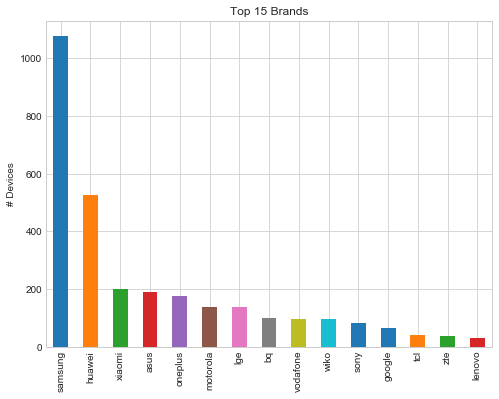

In [11]:
brands = devices.brand.value_counts()
pl = brands[0:15].plot.bar(title='Top 15 Brands', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

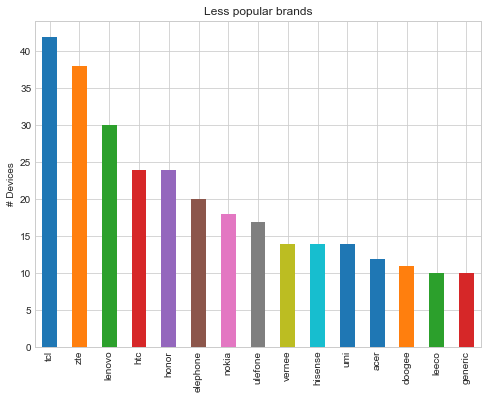

In [12]:
pl = brands[brands.between(10, 50)].plot.bar(title='Less popular brands', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

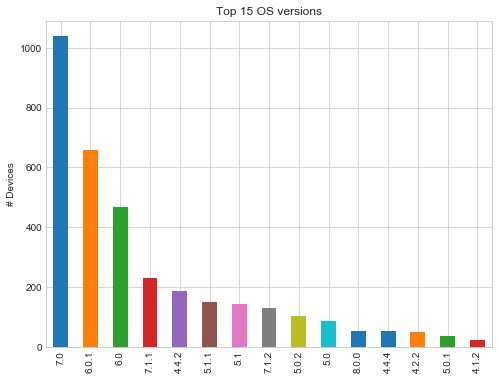

In [13]:
versions = devices.os_version.value_counts()
pl = versions[:15].plot.bar(title='Top 15 OS versions', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

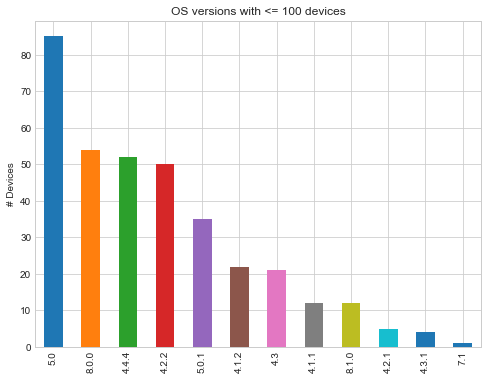

In [14]:
pl = versions[versions <= 100].plot.bar(title='OS versions with <= 100 devices', figsize=figsize)
pl.set(ylabel='# Devices')

### From all devices, is there a significant percentage of rooted devices?
- It seems that **less than 10%** of the devices have root access... We can conclude that only those, within this group, **can run Android custom ROMs** instead of the stock ROM counterparts.

3116 devices do not have root access, while 339 devices are rooted


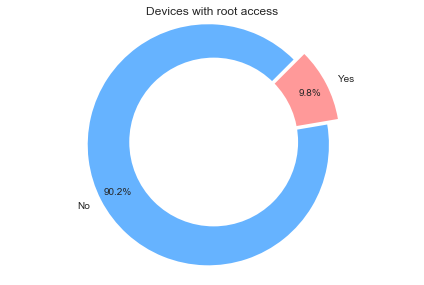

In [15]:
def plot_pie(data, title, labels,
                 colors=['#66b3ff','#ff9999','#99ff99','#ffcc99'], explode=(0.05, 0.05, 0.05, 0.05)):
    fig1, ax1 = plt.subplots()

    ax1.pie(data, colors=colors, labels=labels,
            autopct='%1.1f%%', startangle=45, pctdistance=0.85, explode=explode)

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    fig.suptitle(title)

    ax1.axis('equal')  
    plt.tight_layout()
    
rooted = devices.is_root.value_counts()
plot_pie(rooted, 'Devices with root access', ['No', 'Yes'], ['#66b3ff','#ff9999'], (0.05, 0.05))

print('{0} devices do not have root access, while {1} devices are rooted' \
      .format(rooted[0], rooted[1]))

### How the primary battery and time features are spread out?
- For the next steps we will plot histograms to understand the overview of the sample battery statuses, as well, when devices most frequently register samples.

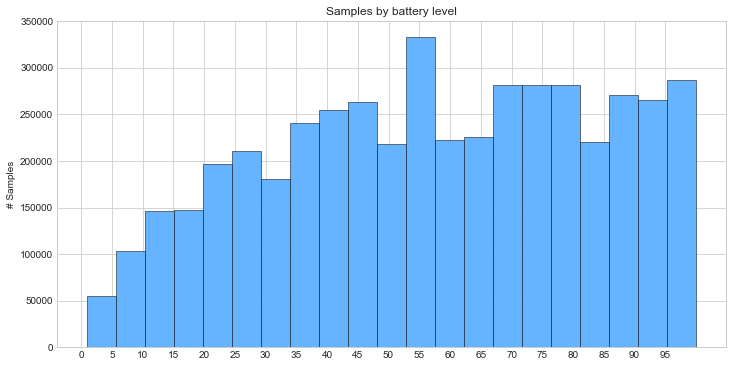

In [16]:
def show_hist(s, bins, title, end=None, start=0, step=1, ylabel='# Samples', color='#66b3ff'):
    s.hist(bins=bins, color=color, edgecolor='k', linewidth=.5, figsize=(12,6))
    if (end != None):
        plt.xticks(np.arange(start, end, step))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
show_hist(samples.battery_level, 21, 'Samples by battery level', 100, step=5)

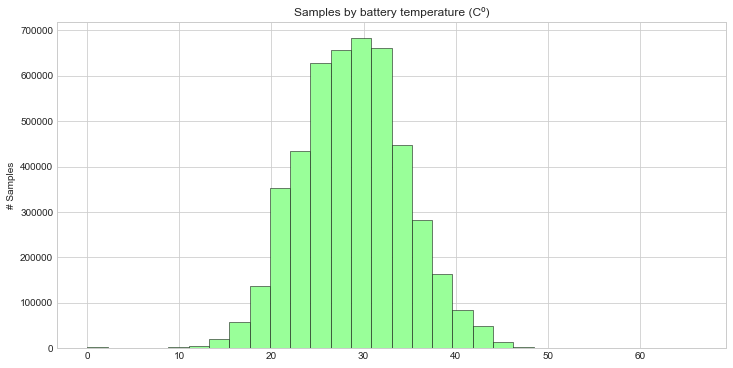

In [17]:
show_hist(samples.temperature, 30, 'Samples by battery temperature (Cº)', color='#99ff99')

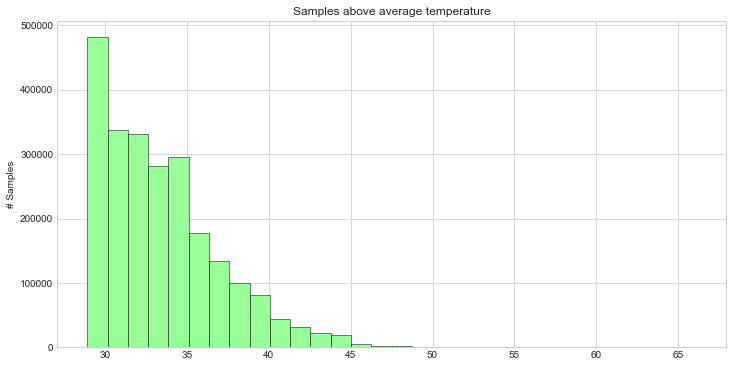

In [18]:
cond = samples.temperature >= samples.temperature.mean()
show_hist(samples[cond].temperature, 30, 'Samples above average temperature', color='#99ff99')

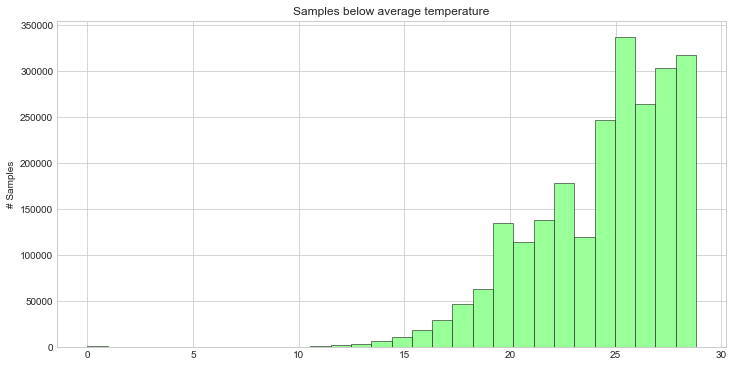

In [19]:
cond = samples.temperature < samples.temperature.mean()
show_hist(samples[cond].temperature, 30, 'Samples below average temperature', color='#99ff99')

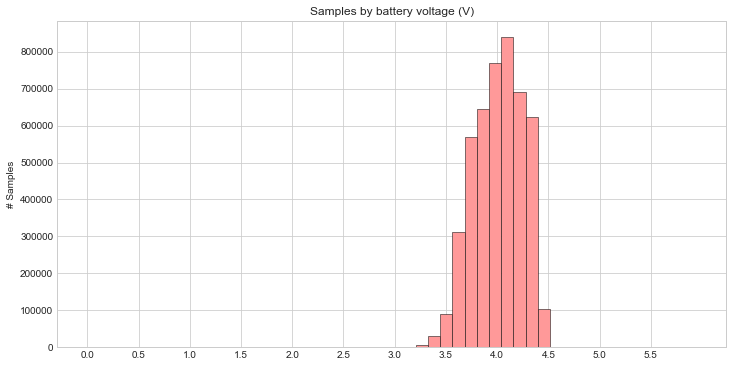

In [20]:
show_hist(samples.voltage, 50, 'Samples by battery voltage (V)', end=6, step=.5, color='#ff9999')

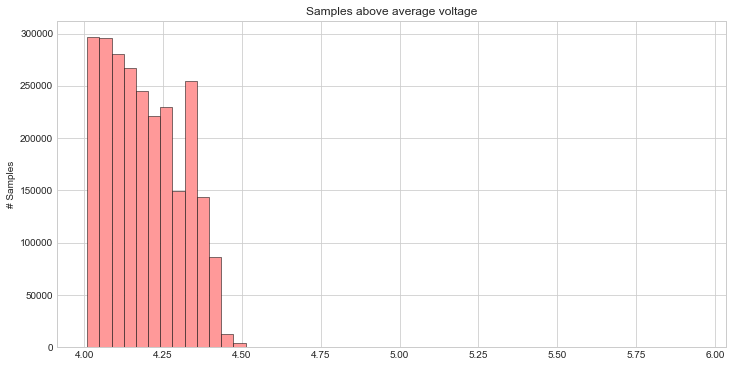

In [21]:
cond = samples.voltage >= samples.voltage.mean()
show_hist(samples[cond].voltage, 50, 'Samples above average voltage', color='#ff9999')

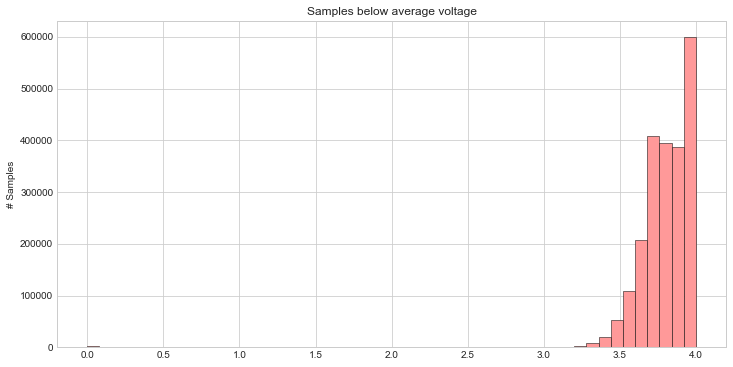

In [22]:
cond = samples.voltage < samples.voltage.mean()
show_hist(samples[cond].voltage, 50, 'Samples below average voltage', color='#ff9999')

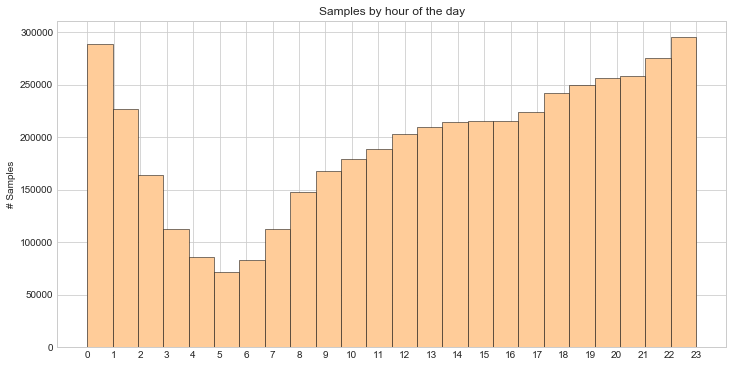

In [23]:
show_hist(samples.timestamp.dt.hour, 24, 'Samples by hour of the day', 24, color='#ffcc99')

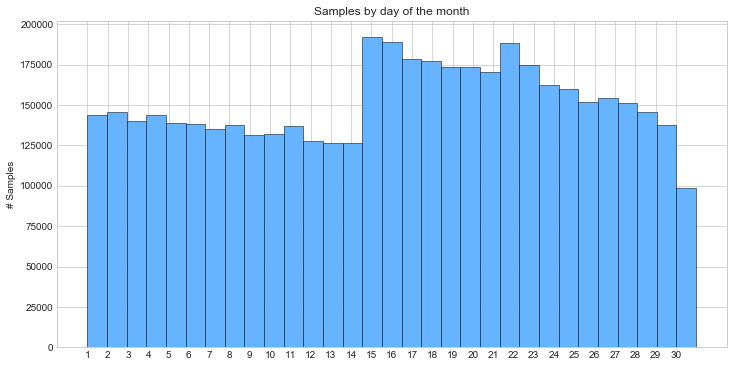

In [24]:
show_hist(samples.timestamp.dt.day, 31, 'Samples by day of the month', 31, start=1, color='#66b3ff')

### It is also important to know which settings devices use the most
- Lets check which settings features are the most often used, later we will combine the settings into classes, representing the possible configurations.

[Text(0,0.5,'# Samples')]

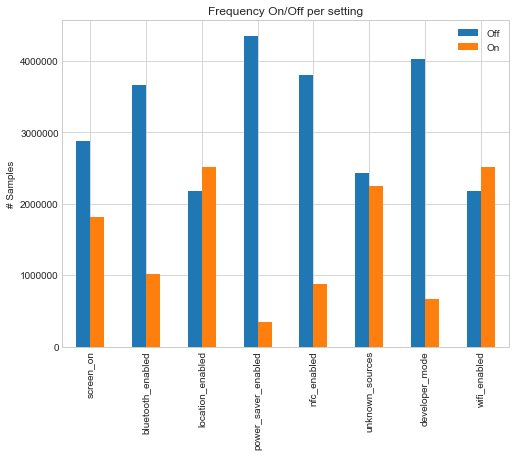

In [25]:
settings = ['screen_on', 'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 
            'nfc_enabled', 'unknown_sources', 'developer_mode', 'wifi_enabled']

# Add new setting
samples['wifi_enabled'] = (samples['network_status'] == 'wifi').astype(np.uint8)

# Frequency on/off per setting
freqs = samples[settings].apply(pd.value_counts, axis=0).T
freqs.columns = ['Off', 'On']
pl = freqs.plot.bar(title='Frequency On/Off per setting', figsize=figsize)
pl.set(ylabel='# Samples')

### How are devices distributed by conversion rates?

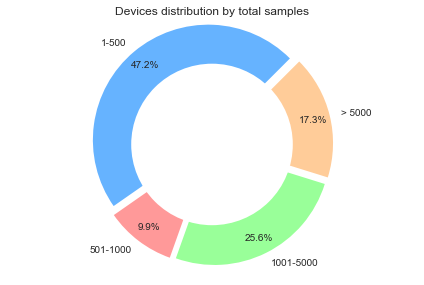

In [26]:
def calculate_blocks(df):
    blocks = pd.DataFrame(df)
    total = blocks.shape[0]
    blocks = blocks[0]
    return [
        blocks[blocks.between(1, 500)].count(),
        blocks[blocks.between(501, 1000)].count(),
        blocks[blocks.between(1001, 5000)].count(),
        blocks[blocks > 5000].count()
    ]

blocks = calculate_blocks(samples.groupby('device_id').size())
plot_pie(blocks, 'Devices distribution by total samples', ['1-500', '501-1000', '1001-5000', '> 5000'])

#### Additionally, we can take a look at the high volume samples results:

In [27]:
def calculate_conversion(limit):
    df = pd.DataFrame(samples.groupby('device_id').size() > limit, columns=['goal'])
    num = df[df.goal].shape[0]
    percentage = round(100 * num / devices.shape[0], 1)
    print('{0:<3} devices have more than {1} samples, that represents {2}%'.format(num, limit, percentage))

calculate_conversion(10000)
calculate_conversion(25000)

123 devices have more than 10000 samples, that represents 3.6%
25  devices have more than 25000 samples, that represents 0.7%


## Transforming Features
1. First, add a new feature *wifi_enabled* (done in the previous step), will tell us if a sample has `wifi` value or some other status. This will be necessary to calculate another feature.
2. Next, calculate the changes over time and battery level, *time_diff* will be the time passed between each sample and *change* the change percentage compared with the previous sample. The latter can be specially useful to group samples in batches of battery levels.
3. We will also add an extra feature *discharging* (`1.0` for discharge state, `0.0` for charge state) which will make it easier to group samples by battery state.
4. Combine the settings values into a numeric class, obtained by converting the group of values into a decimal number.
5. Lastly, drop useless features. We can drop the settings features since we have the *combination* value.

In [28]:
samples['time_diff'] = samples.timestamp.diff()
samples.loc[samples.device_id != samples.device_id.shift(), 'time_diff'] = None

samples['change'] = samples.battery_level - samples.battery_level.shift()
samples.loc[samples.device_id != samples.device_id.shift(), 'change'] = None

samples['discharging'] = samples.battery_level.shift() >= samples.battery_level
samples.loc[samples.device_id != samples.device_id.shift(), 'discharging'] = None

samples['combination'] = np.packbits(samples[settings].values, axis=-1)

samples = samples.drop(settings, axis=1)

samples.sample(5)

,device_id,timestamp,battery_level,network_status,voltage,temperature,time_diff,change,discharging,combination
1280284,828,2018-01-19 12:46:06,17,wifi,4.01,36.500000,00:01:18,1.0,0.0,35
2856917,1975,2017-11-10 21:55:22,59,wifi,4.21,38.700001,00:00:24,2.0,0.0,33
3096188,2119,2017-11-16 00:11:01,80,wifi,4.21,36.400002,00:01:24,1.0,0.0,225
944368,555,2017-11-23 23:54:56,24,wifi,3.96,34.700001,00:01:50,1.0,0.0,161
3720682,2471,2018-03-11 10:00:01,35,wifi,3.86,31.299999,20:01:31,1.0,0.0,137


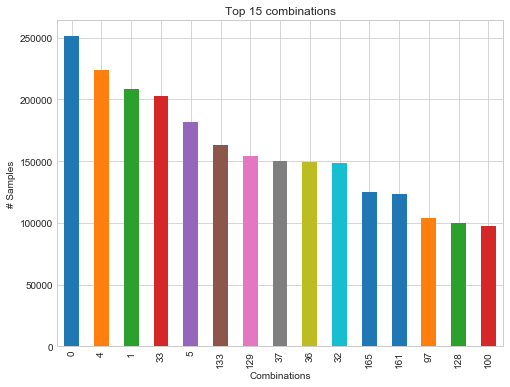

In [29]:
combs = samples.combination.value_counts()
pl = combs[0:15].plot.bar(title='Top 15 combinations', figsize=figsize)
pl.set(xlabel='Combinations', ylabel='# Samples')
plt.show()

### How many samples of each type overall and by device?
Next, we will group the samples by Device and count the samples of each state charging and discharging.
We can also calculate how many devices have each type of sample or even both. We use the *discharging* feature to group them.

The number of samples will differ **according to the sample type filter criteria!**

2370995 are charging samples, while 2313528 are discharging samples


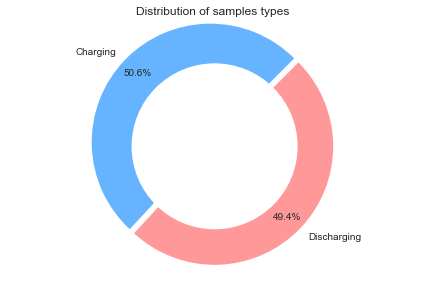

In [30]:
types = samples.discharging.value_counts()

plot_pie(types, 'Distribution of samples types', ['Charging', 'Discharging'],
         ['#66b3ff','#ff9999'], (0.05,0))

print('{0} are charging samples, while {1} are discharging samples' \
      .format(types[0], types[1]))

In [31]:
stypes = samples.groupby('device_id').discharging.value_counts().unstack().fillna(0)
stypes.columns = ['charging', 'discharging']
stypes = stypes.astype(np.int)
stypes = downcast_ints(stypes)

stypes.sample(5)

,charging,discharging
device_id,,
2450,46,20
2597,69,10
2121,18,280
2961,501,128
137,3553,3428


In [32]:
both = stypes[(stypes.charging > 0) & (stypes.discharging > 0)].shape[0]
c_only = stypes[(stypes.charging > 0) & (stypes.discharging == 0)].shape[0]
d_only = stypes[(stypes.charging == 0) & (stypes.discharging > 0)].shape[0]

print('{0} devices have both types of samples, {1} only charging ' \
      'samples and {2} just discharging samples.'.format(both, c_only, d_only))

print('From all {0} unique devices, {1} are counted ' \
      'according to the filter criteria.' \
      .format(samples.device_id.unique().shape[0], stypes.index.unique().shape[0]))

1391 devices have both types of samples, 16 only charging samples and 92 just discharging samples.
From all 1623 unique devices, 1499 are counted according to the filter criteria.


### What is the distribution for battery values like voltage and temperature?
- We will add some additional features for this comparison. We will be looking at **each device's min, max and average** for the **battery temperature** and **voltage**. 

In [33]:
def agg_funcs(df, feature, groupby='device_id'):
    s = df.groupby(groupby)[feature]
    for agg in ['mean', 'min', 'max']:
        col_name = feature[:4] + '_' + agg
        df[col_name] = s.transform(agg)
    return df

samples = agg_funcs(samples, 'temperature')
samples = agg_funcs(samples, 'voltage')

samples.sample(5)

,device_id,timestamp,battery_level,network_status,voltage,temperature,time_diff,change,discharging,combination,temp_mean,temp_min,temp_max,volt_mean,volt_min,volt_max
3128015,2135,2018-01-07 00:45:13,13,wifi,3.80,35.799999,00:01:32,1.0,0.0,143,29.019413,0.0,47.099998,3.931447,2.93,4.36
2462498,1639,2018-05-08 03:31:50,96,wifi,4.35,25.000000,00:04:41,1.0,0.0,5,26.024521,4.0,45.000000,4.007170,3.19,4.40
2285675,1496,2017-12-18 12:57:22,68,wifi,3.91,20.000000,00:16:34,-1.0,1.0,133,23.072529,13.0,44.000000,4.070104,3.42,4.42
2055105,1392,2017-12-02 14:09:49,21,wifi,3.88,27.400000,00:01:54,1.0,0.0,5,29.770105,12.6,45.000000,3.928027,2.98,4.32
1586750,1065,2017-11-09 19:41:27,28,wifi,3.98,28.000000,00:01:40,0.0,1.0,5,27.743526,5.0,46.000000,4.032971,3.34,4.40


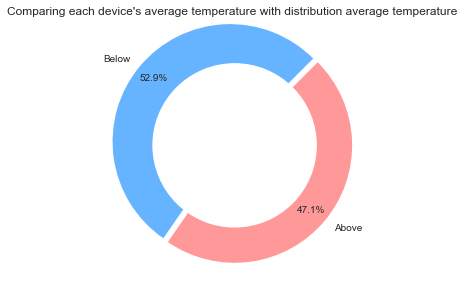

In [34]:
temp_mean = samples.temperature.mean()
samples['temp_comp'] = samples.temp_mean >= temp_mean

plot_pie(samples.temp_comp.value_counts(), 'Comparing each device\'s average temperature with ' \
         'distribution average temperature', ['Below', 'Above'], ['#66b3ff','#ff9999'], (0.05,0))

#### Do the top combinations change for devices above average temperature?

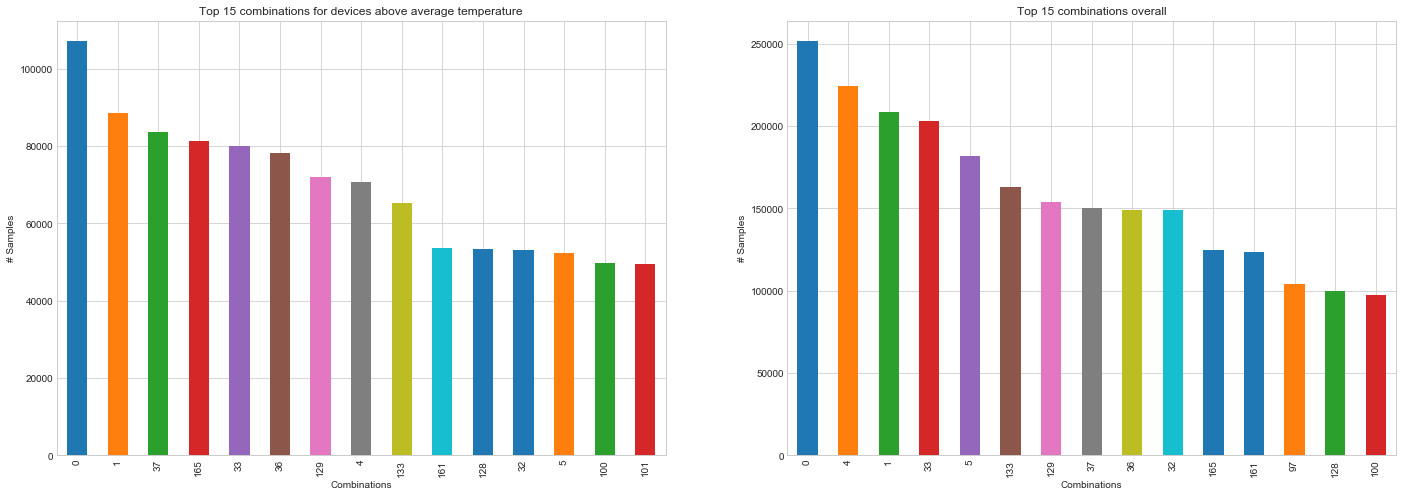

In [35]:
def plot_two_bars(s1, s2, t1, t2):
    fig, ax = plt.subplots(nrows=1, ncols=2)

    fig.set_size_inches(24, 8)
    plt.subplots_adjust(wspace=0.2)

    combs1 = s1.value_counts()
    pl1 = combs1[0:15].plot.bar(title=t1, ax=ax[0])
    pl1.set(xlabel='Combinations', ylabel='# Samples')

    combs2 = s2.value_counts()
    pl2 = combs2[0:15].plot.bar(title=t2, ax=ax[1])
    pl2.set(xlabel='Combinations', ylabel='# Samples')

    plt.show()
    
plot_two_bars(samples[samples.temp_comp].combination, samples.combination,
              'Top 15 combinations for devices above average temperature',
              'Top 15 combinations overall')

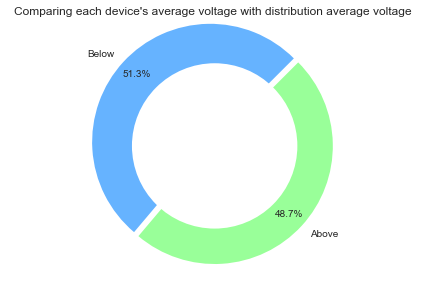

In [36]:
volt_mean = samples.voltage.mean()
samples['volt_comp'] = samples.volt_mean >= volt_mean

plot_pie(samples.volt_comp.value_counts(), 'Comparing each device\'s average voltage with ' \
         'distribution average voltage', ['Below', 'Above'], ['#66b3ff','#99ff99'], (0.05,0))

#### Do the top combinations change for devices above average voltage?

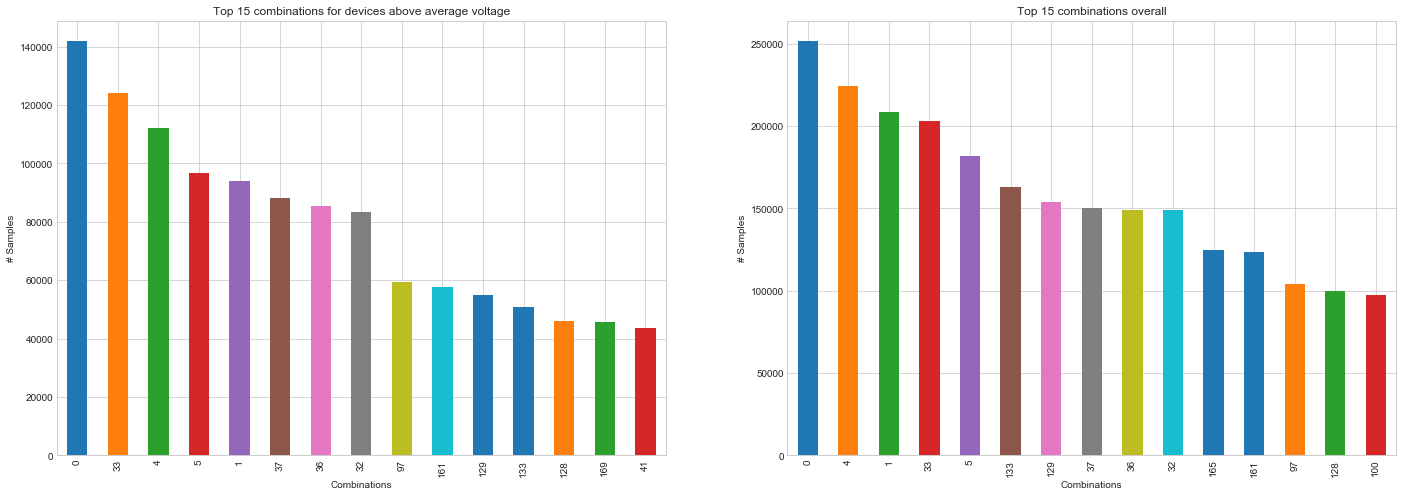

In [37]:
plot_two_bars(samples[samples.volt_comp].combination, samples.combination,
              'Top 15 combinations for devices above average voltage',
              'Top 15 combinations overall')

### What is the distribution of samples with consecutive battery levels?
- Lets try to split the samples in batches of consecutive battery level values, to better understand, what is an average session of usage for a device.
- We will start by selecting only the samples with a **1%** change maximum.

In [38]:
change_interval = samples.change.between(-1, 1)

seqs = samples[change_interval].copy()

seqs['consecutive'] = abs(seqs.battery_level.shift() - seqs.battery_level) <= 1
seqs.loc[seqs.device_id != seqs.device_id.shift(), 'consecutive'] = False
seqs.loc[seqs.discharging != seqs.discharging.shift(), 'consecutive'] = False

def batch_len(s):
    return s * (s.groupby((s != s.shift()).cumsum()).cumcount() + 1)

seqs['batch'] = batch_len(seqs.consecutive)

seqs.shape[0]

4296286

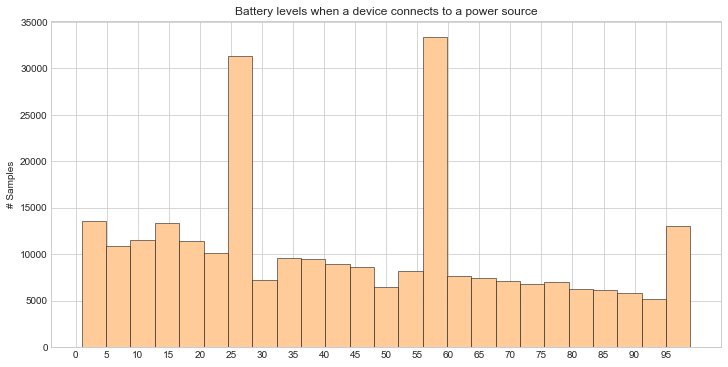

In [39]:
cols = ['device_id', 'timestamp', 'battery_level', 'time_diff', 'change', 'discharging']

changes = samples[cols].copy()

condition = (changes.discharging.shift() == 1) & (changes.discharging == 0)
changes.loc[condition, 'conn_level'] = changes.battery_level.shift()

condition = (changes.discharging.shift() == 0) & (changes.discharging == 1)
changes.loc[condition, 'disc_level'] = changes.battery_level.shift()

show_hist(changes.conn_level, 25, 'Battery levels when a device connects to a power source', 
          color='#ffcc99', end=100, step=5)

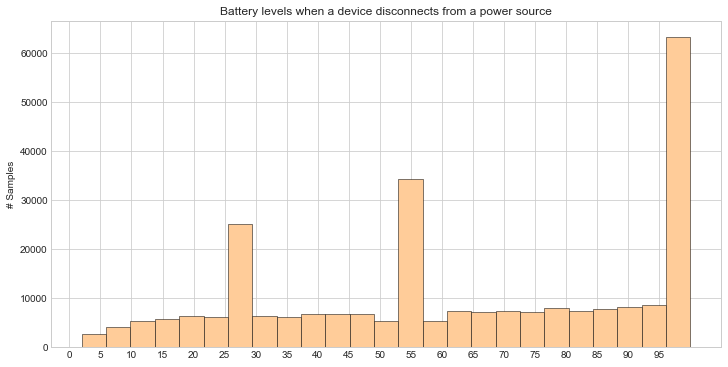

In [40]:
show_hist(changes.disc_level, 25, 'Battery levels when a device disconnects from a power source', 
          color='#ffcc99', end=100, step=5)